In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fetal-detection-and-test/test_set/test_set/245_HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/211_2HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/247_2HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/137_HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/72_HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/213_HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/253_HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/221_HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/78_HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/46_HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/120_HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/123_HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/33_HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/105_3HC.png
/kaggle/input/fetal-detection-and-test/test_set/t

In [2]:
path2data = "../input/fetal-detection-and-test/training_set/training_set"

img_list = [i for i in os.listdir(path2data) if i.find("Annotation") is -1 and i.endswith(".png")]
ann_list = [i for i in os.listdir(path2data) if i.find("Annotation") is not -1]

print(f"# Img list: {len(img_list)}")

print(f"# Annotation list: {len(ann_list)}")

# Img list: 999
# Annotation list: 999


In [3]:
np.random.seed(2019)
rnd_list = np.random.choice(img_list, 3)
rnd_list

array(['584_HC.png', '169_HC.png', '741_HC.png'], dtype='<U11')

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries

In [5]:
def show_img_mask(img,mask):
    img_mask=mark_boundaries(np.array(img), np.array(mask, dtype = np.bool), outline_color=(0,1,0), color=(0,1,0))
    plt.imshow(img_mask)

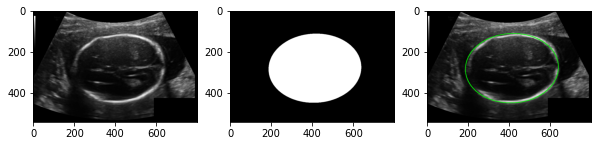

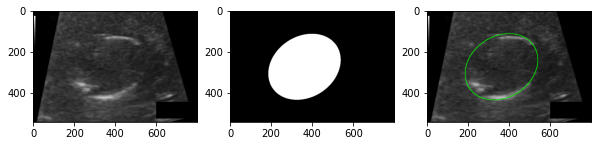

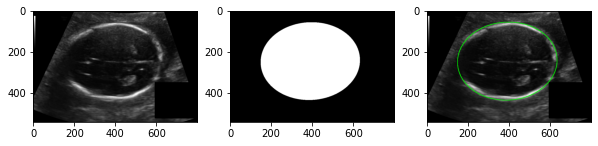

In [6]:
for i in rnd_list:
    path2img = os.path.join(path2data,i)
    path2ann = path2img.replace(".png", "_Annotation.png")
    img = Image.open(path2img)
    annt_edges = Image.open(path2ann)
    mask = ndi.binary_fill_holes(annt_edges)
    
    plt.figure(figsize= (10,10))
    plt.subplot(1,3,1)
    plt.imshow(img, cmap="gray")
    
    
    plt.subplot(1,3,2)
    plt.imshow(mask, cmap="gray")
    
    
    plt.subplot(1,3,3)
    mask = mask*1
    show_img_mask(img,mask)
    

In [7]:
# !conda install -c conda-forge imgaug --yes
# !conda install -c albumentations -c albumentations --yes

In [8]:
from albumentations import (
HorizontalFlip,
VerticalFlip,
Compose,
Resize
)

In [9]:
h,w = 128,192
transform_train = Compose([
    Resize(h,w),
    HorizontalFlip(p = 0.5),
    VerticalFlip(p = 0.5)
])

transform_val = Resize(h,w)


In [10]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch

In [11]:
class fetal_dataset(Dataset):
    def __init__(self, path2data, transform= None):
        img_list = [i for i in os.listdir(path2data) if i.find("Annotation") is -1 and i.endswith(".png")]
        ann_list = [i for i in os.listdir(path2data) if i.find("Annotation") is not -1]
        
        self.path2imgs = [os.path.join(path2data, fn) for fn in img_list]
        
        self.path2annts = [p2i.replace(".png", "_Annotation.png") for p2i in self.path2imgs]
        
        self.transform = transform
        
    def __len__(self):
        return len(self.path2imgs)
    
    def __getitem__(self,idx):
        
        path2img = self.path2imgs[idx]
        image = Image.open(path2img)
        
        path2annt = self.path2annts[idx]
        annt_edges = Image.open(path2annt)
        
        mask = ndi.binary_fill_holes(annt_edges)
        image = np.array(image)
        mask = mask.astype("uint8")
        
        if self.transform:
            augmented = self.transform(image = image, mask = mask)
            image = augmented['image']
            mask = augmented['mask']
            
        image = to_tensor(image)
        mask = 255*to_tensor(mask)
        
        return image, mask

        


In [12]:
fetal_ds1 = fetal_dataset(path2data, transform = transform_train)
fetal_ds2 = fetal_dataset(path2data, transform = transform_val)

print(len(fetal_ds1))
print(len(fetal_ds2))

999
999


In [13]:
img, mask = fetal_ds1[4]
print(img.shape, img.type(), torch.max(img))

print(mask.shape, mask.type(), torch.max(mask))

torch.Size([1, 128, 192]) torch.FloatTensor tensor(0.9529)
torch.Size([1, 128, 192]) torch.FloatTensor tensor(1.)


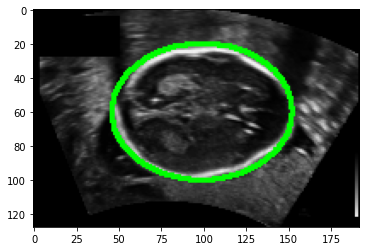

In [14]:
show_img_mask(np.squeeze(img),np.squeeze(mask))

In [15]:
from sklearn.model_selection import ShuffleSplit

In [19]:
sss = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 0)

indices = range(len(fetal_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

799
----------
200


In [21]:
from torch.utils.data import Subset

train_ds = Subset(fetal_ds1, train_index)
print(len(train_ds))

val_ds = Subset(fetal_ds2, val_index)
print(len(val_ds))



799
200


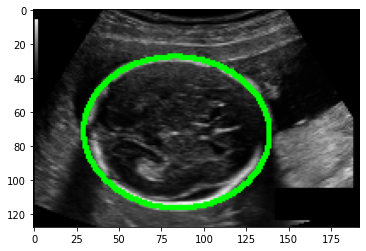

In [24]:
for img,mask in train_ds:
    show_img_mask(np.squeeze(img),np.squeeze(mask))
    break

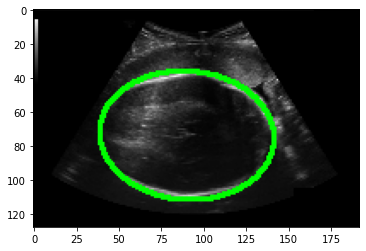

In [25]:
for img,mask in val_ds:
    show_img_mask(np.squeeze(img),np.squeeze(mask))
    break

In [26]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=8, shuffle = True)

val_dl = DataLoader(val_ds, batch_size=16, shuffle = False)

In [27]:
for x,y in train_dl:
    print(x.shape)
    print(y.shape)
    break
for x,y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([8, 1, 128, 192])
torch.Size([8, 1, 128, 192])
torch.Size([16, 1, 128, 192])
torch.Size([16, 1, 128, 192])


## Defining the model

In [28]:
import torch.nn as nn
import torch.nn.functional as F

In [29]:
class SegNet(nn.Module):
    def __init__(self, params):
        super(SegNet, self).__init__()
        C_in, H_in, W_in = params["input_shape"]
        init_f = params["initial_filters"]
        num_outputs = params["num_outputs"]
        
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size = 3, stride = 1, padding = 1)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size = 3, stride = 1, padding = 1)
        self.conv5 = nn.Conv2d(8*init_f, 16*init_f, kernel_size = 3, stride = 1, padding = 1)
        
        self.upsample = nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True)
        
        self.conv_up1 = nn.Conv2d(16*init_f,8*init_f, kernel_size= 3, padding = 1)
        self.conv_up2 = nn.Conv2d(8*init_f,4*init_f, kernel_size= 3, padding = 1)
        self.conv_up3 = nn.Conv2d(4*init_f,2*init_f, kernel_size= 3, padding = 1)
        self.conv_up4 = nn.Conv2d(2*init_f,init_f, kernel_size= 3, padding = 1)
        
        self.conv_out = nn.Conv2d(init_f, num_outputs, kernel_size=3, padding = 1)
        
    def forward(self,x):
        #Encoder
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        
        
        x = F.relu(self.conv5(x))
        
        # Decoder
        x = self.upsample(x)
        x = F.relu(self.conv_up1(x))
        
        
        x = self.upsample(x)
        x = F.relu(self.conv_up2(x))
        
        
        x = self.upsample(x)
        x = F.relu(self.conv_up3(x))
        
        
        x = self.upsample(x)
        x = F.relu(self.conv_up4(x))
        
        x = self.conv_out(x)
        
        return x
        
        
        
        
        

In [33]:
params_model = {
    "input_shape": (1,h,w), 
    "initial_filters": 16,
    "num_outputs": 1,
}
model = SegNet(params_model)

In [34]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(model)

SegNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode=bilinear)
  (conv_up1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
